In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import datetime

# for Markov
import time
import itertools
import collections
from scipy.stats import stats
import statistics

import numpy as np

# Attribution Models
Retailers are always looking to determine how to best advertise to their customers. With the plethora of advertising platform options and more importantly the data supplied by those platforms, the online advertising space has opened up many options for attribution modeling.

The key goal of attribution modeling is to show how effective a certain advertising channel is typically in terms of customer conversions (purchases). One industry standard way to model customer interactions (also known as touch points - for example view an ad, access the website, make a purchase etc.) is to put the interactions in order into a chain. This helps to show the customer's journey towards a conversion or non-conversion.

## First Touch
Just like it says this gives all the credit of the conversion to the first touch point within the chain.

In the following example chain Google Ad would get 100% of the credit.

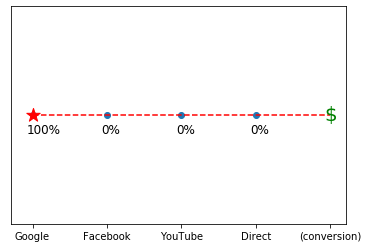

In [2]:
def plot_path(weights):
    fig, ax = plt.subplots()
    x = [0, 1, 2, 3, 4]
    y = [1,1,1,1,1]
    ax.scatter(x[:4], y[:4])
    ax.plot(x, y, 'r--')
    ax.set_xticks(x)
    ax.set_xticklabels(['Google', 'Facebook', 'YouTube', 'Direct', '(conversion)'])
    for r, w in enumerate(weights):
        if w > 0:
            ax.scatter(r, 1, marker='*', s=200, c='red');
        ax.text(r-.075, .9975, f'{w:.0%}', size=12)
    ax.text(3.925, .99925, '$', size=20, color='green')
    ax.get_yaxis().set_visible(False)
plot_path([1,0,0,0])

## Last Touch
The inverse of First Touch it assigns all credit for the conversion to the last touch point within the chain.

In the example chain Direct Webpage access would get 100% of the credit.

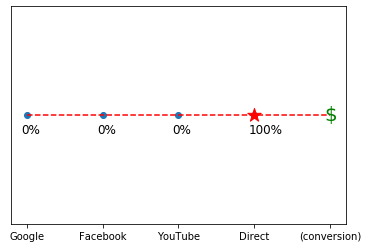

In [3]:
plot_path([0,0,0,1])

## Last Touch Non-Direct
This model is popularized by Google Analytics as this is their preferred method to calculate attribution. This is a twist on the standard Last Touch model which gives the credit to the last touch point within the chain which was **not** a direct access to the website.

In the example chain YouTube would get 100% of the credit.



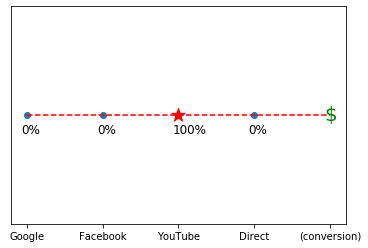

In [4]:
plot_path([0,0,1,0])

## Time Decay
This model gives more credit to the touch points closer to the conversion 

Depending on the time between each touch point our example breakdown would be Google Ad (5%), Facebook Ad (15%), YouTube (30%), Direct (50%).

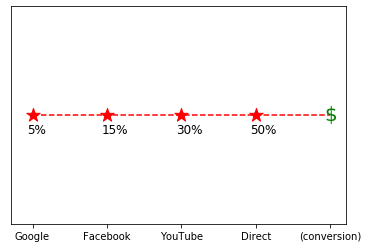

In [5]:
plot_path([.05, .15, .30, .50])

## Linear
Everyone's a winner! Each touch point in the chain is given equal credit.

Each touch point in our example would get 25% (1/4 - excluding the conversion)

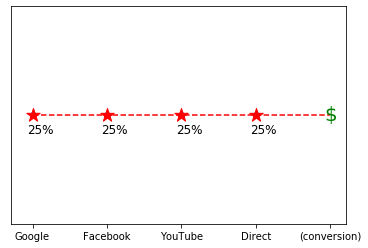

In [6]:
plot_path([.25, .25, .25, .25])

With the advancement in Data Science and the desire to have a more accurate model two other algorithms have risen in popularity: Shapley Values and Markov Chains. 

## Shapley
The Shapley value model was invented by Llyod Shapley in 1953 and has it's roots in game theory. The idea behind this model is that it calculates how much each "player" (touch point) contributes to the final goal (a conversion). It does this by calculating every possible permutation of possibilities of the different players in a matrix and counts the number of conversion that combination of players performed.

Google has recently rolled out this as their "Data Driven" attribution model.

This model complies with the fairness concept which is outlined in four different sections:

1. **Efficiency**
  - The total allocations of all channels must sum to the total payoff. In other words the conversions attributed to each different channel should add up to the total number of conversions
1. **Symmetry**
  - Interchangeable players (channels who contribute the same amount to every coalition) should receive the same allocations
1. **Dummy Player**
  - If the contribution of a player to any coalition is always equal to the payoff that player can generate alone, then that player should receive the amount they can achieve on their own
1. **Additivity**
  - Let's say there's two different games A and B. If the third game C with the characteristic function c such that c(S) = a(S) + b(S) for every coalition S then each player's payoff under game C should be the sum of the payoffs which would have generated separately under games A and B.

#### Positives:
- It has much broader industry adoption and has been used successfully in attribution and auto-bidding platforms for years.
- It’s backed by Nobel Prize winning research.

#### Drawbacks:
- Computationally expensive. As the number of "players" increases the matrix increases exponentially $2^N$ (Using N > 15 is too computationally intensive)
- It doesn't track if a "player" assists multiple times toward the conversion to give them more credit. All players are treated equally.

In [7]:
# Generate some fake data

df = pd.DataFrame(columns=['Customer ID', 'Touchpoint', 'Timestamp'])
random.seed(42)
touch_points = ['Facebook', 'Google', 'Twitter', 'Bing']
N = 20000
N_CUST = 1000
N_DAYS = 180
CONV_PROB = {'Facebook': .001, 'Google': .1, 'Twitter':.02, 'Bing': 0.05}


for i in range(N):
    tp = touch_points[random.randint(1, len(touch_points))-1]
    cid = random.randint(1, N_CUST)
    days = random.random() * N_DAYS
    ts = datetime.datetime.now() - datetime.timedelta(days=days)
    prob = CONV_PROB[tp]
    df = df.append(pd.DataFrame({'Customer ID':[cid],
                                 'Touchpoint':[tp],
                                 'Timestamp':[ts],
                                 'conversion': random.choices([0,1], weights=[(1-prob), prob], k=1)}),
                  sort=False)

#df['conversion'] = random.choices([0,1], weights=[(1-CONV_PROB), CONV_PROB], k=len(df.index))
df = df.sort_values(by=['Customer ID', 'Timestamp']).set_index(['Customer ID', 'Timestamp'])

df.head(20)

Touchpoint  conversion
Customer ID Timestamp                                        
1           2019-05-13 12:53:37.957484     Google         0.0
            2019-05-15 15:37:31.194717       Bing         0.0
            2019-05-20 03:25:06.655348     Google         0.0
            2019-05-27 15:34:04.176696     Google         0.0
            2019-06-08 05:38:07.008084     Google         0.0
            2019-06-30 04:27:12.696471       Bing         1.0
            2019-07-15 08:57:30.262211     Google         0.0
            2019-07-21 13:45:02.556646   Facebook         0.0
            2019-07-29 06:46:22.149698   Facebook         0.0
            2019-08-06 03:24:56.778906   Facebook         0.0
            2019-08-07 19:16:55.412239   Facebook         0.0
            2019-08-23 01:01:54.340719    Twitter         0.0
            2019-08-24 17:08:42.255425    Twitter         0.0
            2019-08-27 23:09:58.697808       Bing         0.0
            2019-09-01 06:51:33.746471     Google         0.0
            2019-09-09 05:02:08.982010       Bing         0.0
            2019-09-19 06:00:48.849630   Facebook         0.0
            2019-09-23 14:34:39.363668       Bing         0.0
            2019-09-24 21:03:54.173611     Google         0.0
            2019-10-15 04:29:52.184999       Bing         0.0

Once the initial dataset is generated it then needs to be processed to determine the time difference between each event. This is because an event from two years ago typically shouldn't count towards a customer's conversion today. 

A chain is marked as complete / ended under two different scenarios - either the customer converts (makes a purchase) or there are no more interactions with the customer after a certain time period (no conversion).

The next step is to shift the dataset and merge it to itself to calculate the time duration between each touchpoint

In [8]:
delim = '>'

# Days until we declare no conversion
T_WINDOW = 30

# Shift the dataset within each customer id to offset
# the touchpoint to allow it to be merged upon itself
df_prior = df.reset_index().groupby(['Customer ID']).shift(1)

# Merge the original and shifted dataset together and
# calculate the time difference between the two touchpoints
df_final = pd.merge(right = df.reset_index()
        ,left = df_prior,
        left_index = True,
        right_index = True,
        suffixes=('_Prior', ''))
df_final['Timestamp_Prior'] = df_final['Timestamp_Prior'].fillna(df_final['Timestamp'])

df_final['Days Diff'] = (df_final['Timestamp'] - df_final['Timestamp_Prior']).dt.days

# Determine if there is a new session
# - > 30 days OR
# - Made a conversion in the prior step.
df_final['New Session'] = df_final.apply(lambda r: ((r['Days Diff'] > 30) or (r['conversion_Prior'] == 1)), axis=1)
df_final['New Session'] = df_final['New Session'].astype(int)

# Assign a session ID (Customer ID + session number)
df_final['SessionID'] = df_final['Customer ID'].astype(str) + '-' + (df_final.groupby(['Customer ID'])['New Session'].cumsum() + 1).astype(str)

df_final.head(20)

,Timestamp_Prior,Touchpoint_Prior,conversion_Prior,Customer ID,Timestamp,Touchpoint,conversion,Days Diff,New Session,SessionID
0,2019-05-13 12:53:37.957484,NaN,NaN,1,2019-05-13 12:53:37.957484,Google,0.0,0,0,1-1
1,2019-05-13 12:53:37.957484,Google,0.0,1,2019-05-15 15:37:31.194717,Bing,0.0,2,0,1-1
2,2019-05-15 15:37:31.194717,Bing,0.0,1,2019-05-20 03:25:06.655348,Google,0.0,4,0,1-1
3,2019-05-20 03:25:06.655348,Google,0.0,1,2019-05-27 15:34:04.176696,Google,0.0,7,0,1-1
4,2019-05-27 15:34:04.176696,Google,0.0,1,2019-06-08 05:38:07.008084,Google,0.0,11,0,1-1
5,2019-06-08 05:38:07.008084,Google,0.0,1,2019-06-30 04:27:12.696471,Bing,1.0,21,0,1-1
6,2019-06-30 04:27:12.696471,Bing,1.0,1,2019-07-15 08:57:30.262211,Google,0.0,15,1,1-2
7,2019-07-15 08:57:30.262211,Google,0.0,1,2019-07-21 13:45:02.556646,Facebook,0.0,6,0,1-2
8,2019-07-21 13:45:02.556646,Facebook,0.0,1,2019-07-29 06:46:22.149698,Facebook,0.0,7,0,1-2
9,2019-07-29 06:46:22.149698,Facebook,0.0,1,2019-08-06 03:24:56.778906,Facebook,0.0,7,0,1-2


The next step is to flatten the touchpoints based on the session ID to allow for easier parsing later.

In [9]:
dfcsv = df_final.groupby('SessionID')[['Touchpoint']].agg(lambda x: delim.join(x))
dfcsv_uniq = df_final.groupby('SessionID')[['Touchpoint']].agg(lambda x: delim.join(set(x)))
#dfcsv = dfcsv.drop_duplicates()
dfconv = df_final.groupby('SessionID')['conversion'].agg(lambda x: max(x))
dfcsv['conversion'] = dfconv
dfcsv_uniq['conversion'] = dfconv
dfcsv

,Touchpoint,conversion
SessionID,,
1-1,Google>Bing>Google>Google>Google>Bing,1.0
1-2,Google>Facebook>Facebook>Facebook>Facebook>Twi...,0.0
10-1,Google>Bing>Facebook>Bing>Twitter>Facebook>Fac...,1.0
10-2,Twitter>Facebook>Bing>Bing>Bing>Twitter>Bing>F...,1.0
10-3,Bing>Bing,0.0
100-1,Bing>Facebook>Facebook>Bing>Bing>Bing>Facebook...,0.0
100-2,Google,1.0
100-3,Twitter>Bing>Bing>Facebook>Google>Google,1.0
100-4,Google>Twitter>Facebook>Bing>Google>Google,0.0


In [10]:
df_shap = dfcsv_uniq.groupby('Touchpoint').sum().sort_index()
df_shap

,conversion
Touchpoint,
Bing,45.0
Facebook,1.0
Facebook>Bing,14.0
Google,83.0
Google>Bing,49.0
Google>Bing>Facebook,19.0
Google>Facebook,18.0
Google>Facebook>Bing,36.0
Google>Twitter,27.0


In [11]:
# Populate all possible permucations based on the touch points
# Make into a CSV list to combine with the data we prevoisly had
import itertools
touch_list = []
for s in range(len(touch_points)):
    l = list(itertools.permutations(touch_points, s+1))
    for tp in l:
        touch_list.append(delim.join(tp))

In [12]:
# Append the two and then recalculate the sum of conversion
df_tps = pd.DataFrame([0]*len(touch_list), index=touch_list, columns=['conversion'])
df_final_shap = df_shap.append(df_tps)
df_final_shap = df_final_shap.groupby([df_final_shap.index.get_level_values(0)]).sum()

In [13]:
df_final_shap

,conversion
Bing,45.0
Bing>Facebook,0.0
Bing>Facebook>Google,0.0
Bing>Facebook>Google>Twitter,0.0
Bing>Facebook>Twitter,0.0
Bing>Facebook>Twitter>Google,0.0
Bing>Google,0.0
Bing>Google>Facebook,0.0
Bing>Google>Facebook>Twitter,0.0
Bing>Google>Twitter,0.0


In [14]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return map(delim.join,map(sorted,sub_channels))


# Calculate the Value function to determine
# the worth of each coalition
def v_function(channels, conversion_values):
    s_of_A = subsets(channels.split(delim))
    worth_of_A = 0
    for subset in s_of_A:
        worth_of_A += conversion_values.loc[subset, 'conversion']
    return worth_of_A


# Do the Shapley calculations
v_values = {}
for A in subsets(touch_points):
    v_values[A] = v_function(A, df_final_shap)
    

from collections import defaultdict
from math import factorial

n=len(touch_points)
shapley_values = defaultdict(int)

for channel in touch_points:
    for A in v_values.keys():
        if channel not in A.split(delim):
            cardinal_A=len(A.split(delim))
            A_with_channel = A.split(delim)
            A_with_channel.append(channel)            
            A_with_channel=delim.join(sorted(A_with_channel))
            shapley_values[channel] += (v_values[A_with_channel]-v_values[A])*(factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
    # Add the term corresponding to the empty set
    shapley_values[channel]+= v_values[channel]/n 

In [15]:
shapley_values

defaultdict(int,
            {'Facebook': 1.0, 'Google': 96.5, 'Twitter': 31.5, 'Bing': 45.0})

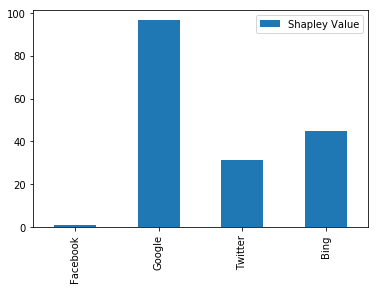

In [16]:
df_values = pd.DataFrame(shapley_values.values(), index=shapley_values.keys())
df_values.plot.bar()
L=plt.legend()
L.get_texts()[0].set_text('Shapley Value')

## Markov Chains

Markov chains is a process which maps the movement and gives a probability distribution, for moving from one state to another state. A Markov Chain is defined by three properties:

- State space – set of all the states in which process could potentially exist
- Transition operator –the probability of moving from one state to other state
- Current state probability distribution – probability distribution of being in any one of the states at the start of the process

For more indepth reading refer to the research paper https://www.researchgate.net/publication/258316917_Mapping_the_Customer_Journey_A_Graph-Based_Framework_for_Online_Attribution_Modeling

### Removal Effect
Removal effect principle says that to determine the contribution of each channel/touchpoint in the customer journey each channel is removed and then the number of conversion are calculated without that channel in place. The share difference is how much that channel contributes.

### Pros:
- Less memory intensive than Shapley - $N^2$ instead of $2^N$ size matrix needed.
- Can account for customers going to the same touchpoint multiple times
- Considers channel sequence as a fundamental part of the algorithm which is more closely aligned to a customer’s journey.
- Can go to a more granular level (like campaign)

### Representation
Markov models can be represented as either a state (probability) matrix or a state space graph as displayed below.

Example State Space Graph


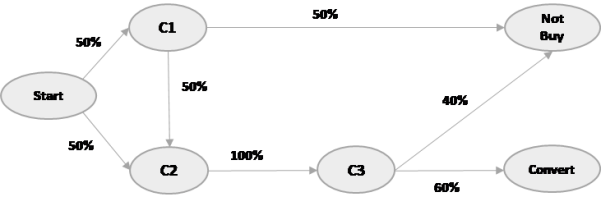

In [17]:
from IPython.display import Image
print("Example State Space Graph")
Image('markov_model.png')

In [18]:
# Initialize the empty state space
tps = list(df['Touchpoint'].unique()) + ['(start)', '(conversion)', '(no conversion)']
state_matrix = pd.DataFrame(columns=tps, index = pd.Index(tps)).fillna(0)

In [19]:
state_matrix

,Google,Bing,Facebook,Twitter,(start),(conversion),(no conversion)
Google,0,0,0,0,0,0,0
Bing,0,0,0,0,0,0,0
Facebook,0,0,0,0,0,0,0
Twitter,0,0,0,0,0,0,0
(start),0,0,0,0,0,0,0
(conversion),0,0,0,0,0,0,0
(no conversion),0,0,0,0,0,0,0


In [20]:
# Calculate the state matrix
for idx, r in df_final.iterrows():
    tp = r['Touchpoint']
    tpp = r['Touchpoint_Prior']

    if (r['conversion'] == 0 and
        (idx == len(df_final.index)-1 or
            df_final.loc[idx+1, 'SessionID'] != r['SessionID'])):
        state_matrix.loc[tp, '(no conversion)'] += 1
    
    if (pd.isnull(r['Touchpoint_Prior']) or
        df_final.loc[idx-1, 'SessionID'] != r['SessionID']):
            state_matrix.loc['(start)', tp] += 1
    else: 
        state_matrix.loc[tpp, tp] += 1
    
    if r['conversion'] == 1:
        state_matrix.loc[tp, '(conversion)'] += 1

In [21]:
# Calculate the probability of each state
prob_matrix = state_matrix.apply(lambda x: x / x.sum(), axis=1).fillna(0)
prob_matrix.columns.name = 'From ↓  To →'
prob_matrix = prob_matrix.drop(columns='(start)')
prob_matrix

From ↓ To →,Google,Bing,Facebook,Twitter,(conversion),(no conversion)
Google,0.208511,0.213779,0.206282,0.202229,0.101317,0.067882
Bing,0.217237,0.224911,0.219599,0.215860,0.051555,0.070838
Facebook,0.224155,0.227318,0.245898,0.227713,0.000395,0.074521
Twitter,0.224817,0.231519,0.226239,0.223193,0.020715,0.073517
(start),0.243913,0.258261,0.246522,0.251304,0.000000,0.000000
(conversion),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(no conversion),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The final step in the Markov chain method is to utilize the Removal Effect principal. Each channel is removed from the graph / probability matrix and measure how many conversions could be made without that channel. The method that will be used is based on the probability matrix for each channel.

Simply put: We convert each channel to a (no conversion) and see how the probability of a conversion changes compared to the probability with the channel included.

To do this we can simulate the number of conversions using the probability matrix many times and again with the new probability matrix where a specific channel is a termination node i.e. (no conversion)

In [22]:
def simulation(prob_matrix,n):
    ''' Function to run n-length simulation based on the given probability matrix'''
    sim=['']*n
    sim[0]= '(start)'
    i=1
    while i<n:
        sim[i] = np.random.choice(prob_matrix.columns, 1, p=prob_matrix.loc[sim[i-1],:])[0]
        if sim[i] == '(conversion)':  # ['(conversion)', '(no conversion)']:
            break
        elif sim[i] == '(no conversion)':
            return [None]
        i=i+1

    return sim[0:i+1]

In [23]:
def markov_chain(prob_matrix,
                 num_iteration=10,
                 num_simulation=10000,
                 alpha=5):
    
    df_all_runs = pd.DataFrame()

    # for each number of iterations
    # run a simulation
    # determine how many paths would be affected
    #   if that node/channel was removed
    # assign the number of conversions it contributed to
    for k in range(0,num_iteration):
        start = time.time()
        
        p=[]
        channel_list = [k for k in prob_matrix.columns
                        if k not in ['(start)', '(conversion)', '(no conversion)']]
        i=0
        while i<num_simulation:
            single_path = set(simulation(prob_matrix, 1000))
            if single_path:
                p.append(single_path)
            i=i+1

        path=list(itertools.chain.from_iterable(p))
        counter=collections.Counter(path)

        df_touchpoint_counts=pd.DataFrame({'count':list(counter.values()), 'path':list(counter.keys())})
        
        df_convs=(pd.DataFrame(df_touchpoint_counts.groupby(['path'])[['count']].sum())).reset_index()

        df_convs['Removal Effect']=df_convs['count']/len(path)
        #df1['removal_effects']=df1['count']/sum(df1['count'][df1['path']=='convert'])
        df_convs=df_convs[df_convs['path'].isin(channel_list)]
        df_convs['Simulated Conversions']=df_convs['Removal Effect']/sum(df_convs['Removal Effect'])

        df_convs['Simulated Conversions']=df_convs['Simulated Conversions']*counter['(conversion)']

        df_all_runs = df_all_runs.append(df_convs, ignore_index=True)
        end = time.time()
        t1=(end - start)

    '''
    H0: u=0
    H1: u>0
    '''

    unique_channel=list(set(df_all_runs['path']))

    final_df=pd.DataFrame()

    # Run a T-test on our data to determine if it's statistically significant
    for i in range(0,len(unique_channel)):

        x=(df_all_runs['Simulated Conversions'][df_all_runs['path']==unique_channel[i]]).values
        final_df.loc[i,0]=unique_channel[i]
        final_df.loc[i,1]=x.mean()

        v=stats.ttest_1samp(x,0)
        final_df.loc[i,2]=v[1]/2

        if v[1]/2<=alpha/100:
            final_df.loc[i,3]=str(100-alpha)+'% statistical confidence'
        else:
            final_df.loc[i,3]=str(100-alpha)+'% statistical no confidence'

        final_df.loc[i,4]=len(x)
        final_df.loc[i,5]=statistics.stdev(x)
        final_df.loc[i,6]=v[0]

    final_df.columns=['Channel','Simulated Conversions','p_value','Confidence','Frequency','Standard Deviation','t_statistics']       
    final_df['Simulated Conversions']=counter['(conversion)'] *final_df['Simulated Conversions'] /sum(final_df['Simulated Conversions'])

    return final_df,df_convs

df_results = markov_chain(prob_matrix)

In [24]:
df_results[1]

,path,count,Removal Effect,Simulated Conversions
2,Bing,2899,0.116258,971.170182
3,Facebook,2512,0.100738,841.524491
4,Google,3153,0.126444,1056.260636
5,Twitter,2624,0.105229,879.044691


# Conclusion
There are many different attribution models avaialable and as they gain in popularity more are becoming more available. Currently, however Python doesn't have widely accepted packages for Markov or Shapley models. R is more advanced in this area and has a nice Markov model package called ChannelAttribution.

I hope this notebook has been helpful in not only explaining each attribution model but also giving technical examples how each model works.